In [39]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# 5개 베이스 모델 사용
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [5]:
! pip install plotly

# Feature Exploration, Engineering and Cleaning

In [6]:
# 데이터셋 불러오기
train = pd.read_csv("Dataset/Titanic/train.csv")
test= pd.read_csv("Dataset/Titanic/test.csv")

# passengerID 는 따로 변수에 저장
PassengerId= test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering

In [7]:
full_data = [train,test]

In [8]:
# 추가한 피쳐들
# 이름의 길이
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# cabin 값 있으면 따로 컬럼으로 표시
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) ==float else 1)

In [9]:
# FamilySize 컬럼 만들기
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# 혼자 왔으면 IsAlone 1 대입
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] =1

# Embarked 결측치 채우기
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [10]:
# Fare 컬럼 결측치 중앙값으로 채우기
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] =pd.cut(train['Fare'],4)

In [11]:
# Age 나눠서 범주형 피쳐 만들기 (결측치는 평균과 분산을 이용해 분포에 맞춰 랜덤값 채우기)
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std= dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list=np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'],5)

# 이름에서 title 추출하는 함수 만들기
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    # title 있으면 추출하고 return
    if title_search:
        return title_search.group(1)
    return ""

# Title 피쳐 만들기
for dataset in full_data:
    dataset['Title'] =dataset['Name'].apply(get_title)

# Title 중 마이너들은 Rare로 변경
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace("Ms",'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

for dataset in full_data:
    # 성별 매핑
    dataset['Sex']= dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Title 매핑
    title_mapping= {"Mr":1, "Miss":2,'Mrs':3, 'Master':4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Embarked 매핑
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    # Fare 매핑
    dataset.loc[dataset['Fare']<=7.91 ,'Fare']  = 0 
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.45), 'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.45)&(dataset['Fare']<=31), 'Fare'] =2
    dataset.loc[dataset['Fare']>31, 'Fare'] =3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Age 매핑
    dataset.loc[dataset['Age']<=16, 'Age'] =0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32), 'Age'] =1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48), 'Age'] =2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64), 'Age'] =3
    dataset.loc[dataset['Age']>64,'Age'] =4
    
    

In [12]:
# Feature 선택
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train= train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge','CategoricalFare'],axis=1)
test= test.drop(drop_elements, axis=1)

In [13]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


## Pearson Correlation Heatmap

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

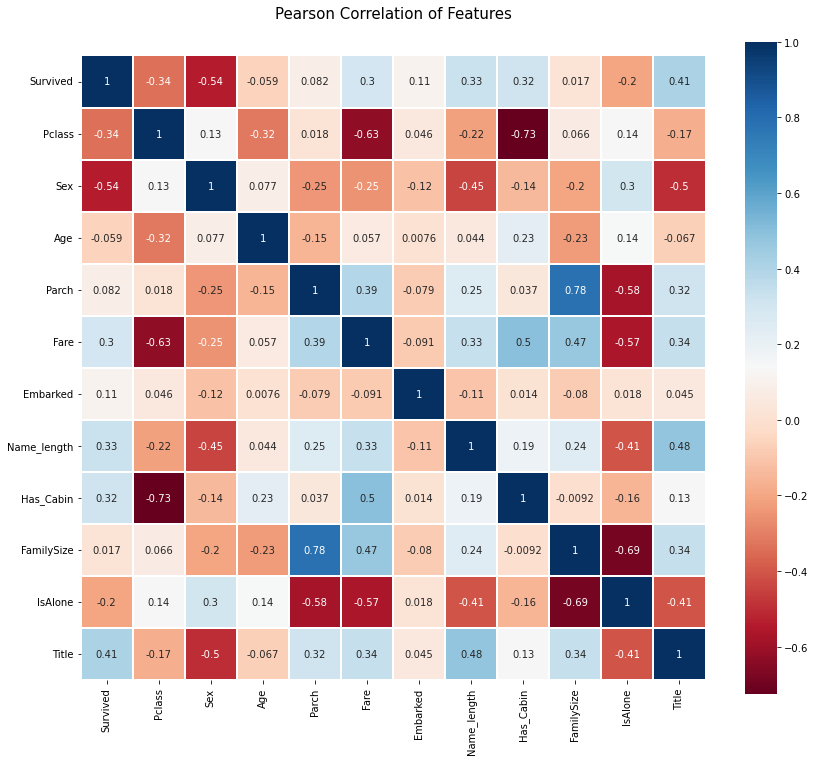

In [14]:
colormap= plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

- 피쳐 간 상관관계가 깊은 것은 거의 없다. -> 머신러닝 모델에 학습하기 좋다. (각자 독립적인 정보를 갖고있다.)

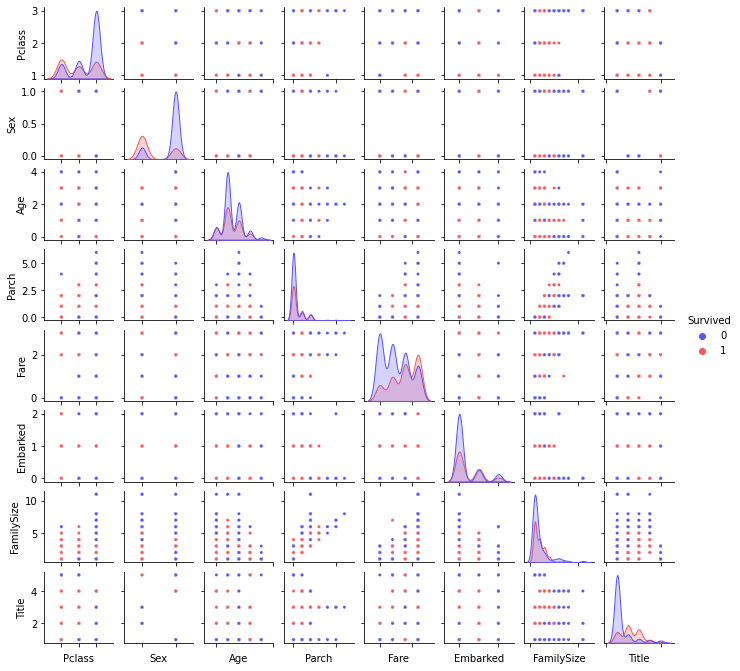

In [15]:
g= sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette='seismic'
               , size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models

In [40]:
# 쓸만한 파라미터
ntrain =train.shape[0]
ntest = test.shape[0]
SEED = 0 # 재현성
NFOLDS = 5 # 폴드 횟수
kf = KFold(ntrain, shuffle=False)

# 클래스화
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf= clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importance(self,x,y):
        print(self.clf.fit(x,y).feature_importance_)
    

In [43]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

# Generating our Base First-Level Models

In [24]:
# 1단계 모델링

# Random Forest 파라미터
rf_params={
    'n_jobs':-1,
    'n_estimators':500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf':2,
    'max_features': 'sqrt',
    'verbose':0
}

# Extra Trees 파라미터
et_params={
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0
}

# AdaBoost parameters
ada_params ={
    'n_estimators':500,
    'learning_rate':0.75
}

# Gradient Boosting 파라미터
gb_params ={
    'n_estimators':500,
    'max_depth':5,
    'min_samples_leaf':2,
    'verbose':0
}

# SVM 파라미터

svc_params={
    'kernel':'linear',
    'C':0.025
}

In [30]:
# 5개 객체 만들기
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

et = SklearnHelper(clf=ExtraTreesClassifier, seed= SEED, params=et_params)

ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)

gb = SklearnHelper(clf=GradientBoostingClassifier, seed= SEED, params=gb_params)

svc= SklearnHelper(clf=SVC, seed= SEED, params=svc_params)

## 훈련 및 테스트 세트에서 NumPy arrays  생성

In [31]:
# Numpy array 생성

y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values

## 첫 단계 예측 결과

In [45]:
et_oof_train, et_oof_test = get_oof(et,x_train,y_train,x_test)

rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)

ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)

gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)

svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print("Training 완료")

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))